# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
from PIL import Image

# Libraries for showing random samples
from numpy import random
import matplotlib
import matplotlib.pyplot as plt

import keras
from keras import layers



# Import Data
IN this section, the following tasks are done


1.   Importing the MNIST handwritten digit dataset from tensorflow.keras.datasets and unpack the x train/test set and the y train/test set([Ref](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data?_gl=1*rt9ejc*_up*MQ..*_ga*NDI3MTg5MDAwLjE3MzAyNTM3NzQ.*_ga_W0YLR4190T*MTczMDI1Mzc3NC4xLjAuMTczMDI1Mzc3NC4wLjAuMA..))
2.   Investigate the size of the train and test sets, including the features and the label in each set
3.   Normalize the data to a range of [0,1] for better training convergence.
4.   Visualize the input of the dataset by displaying 25 random samples



In [2]:
# Load the MNIST dataset
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = mnist.load_data()

# Showing the dimension of the 4 sets
print(f"Dimension of the x_train set: {x_train_raw.shape} \n"
      f"Dimension of the y_train set: {y_train_raw.shape} \n"
      f"Dimension of the x_test set: {x_test_raw.shape} \n"
      f"Dimension of the y_test set: {y_test_raw.shape}")

# Normalize the input pixels from a range of [0,255] to [0,1]
x_train = x_train_raw/-255
x_test = x_test_raw/-255

input_shape = (28,28,1)
output_classes = 10

Dimension of the x_train set: (60000, 28, 28) 
Dimension of the y_train set: (60000,) 
Dimension of the x_test set: (10000, 28, 28) 
Dimension of the y_test set: (10000,)


By running the code block above, it can be seen that

*  60,000 samples in the dataset are used in training.
*  10,000 samples are usedfor testing (approx 85/15 split)
*  The input map has the size of 28x28



In the code block below, we can inspect the label column of the dataset to see how the desired labels are given.

In [3]:
y_train_raw

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

When run, the block returns an array of the training labels as the single integer output for each instances. However, I will later train a network to output a probability distribution of 10 different classes, each representing the digit from 0 to 9.

Therefore, I must use one-hot encoding to convert these single integer labels into $1\times10$ vectors. The code block below performs this operation and display the dimension of the training and testing labels

In [4]:
# One hot encode the label
y_train = to_categorical(y_train_raw, num_classes=output_classes)
y_test = to_categorical(y_test_raw,num_classes=output_classes)

print(f"Dimension of the y_train set: {y_train.shape} \n"
      f"Dimension of the y_test set: {y_test.shape}")

Dimension of the y_train set: (60000, 10) 
Dimension of the y_test set: (10000, 10)


The code block below is used for visualizing random handwritten digit samples in the dataset

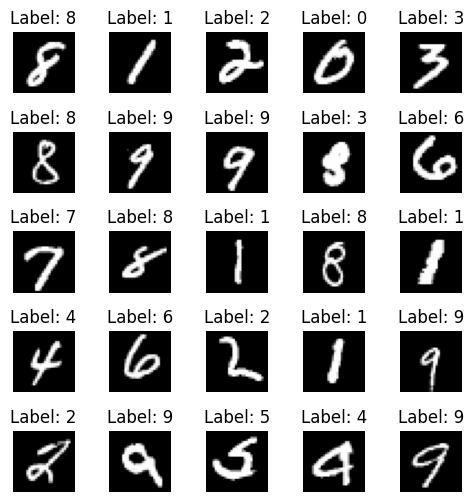

In [5]:
num_samples = 25
rand = random.randint(60000,size = (num_samples))
x_samples = x_train[rand,:,:]
y_samples = np.argmax(y_train[rand,:],axis=1)

fig, axes = plt.subplots(5,5,figsize=(5,5))

for i in range(5):
  for j in range(5):
    ax = axes[i,j]
    ax.imshow(x_samples[i*5+j,:,:], cmap=matplotlib.cm.Greys)
    ax.axis("off")
    ax.set_title(f"Label: {y_samples[i*5+j]}")

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust top to make room for title
plt.show()


# Helper Functions

In [6]:
def plot_performance(history, learning_rate=None, batch_size=None):
  fig1, axes1 = plt.subplots(1,2,figsize = (10,5))

  # Accuracy of model training and validation vs training epoch
  acc_ax = axes1[0]
  acc_ax.plot(history.history['accuracy'])
  acc_ax.plot(history.history['val_accuracy'])

  if learning_rate and batch_size:
    acc_ax.set_title(f'Model accuracy \n lr = {learning_rate}, batch size = {batch_size}')
  else: acc_ax.set_title('Model accuracy')

  acc_ax.set_ylabel('Accuracy')
  acc_ax.set_xlabel('Epoch')
  acc_ax.legend(['Training', 'Validation'], loc='best')

  # Loss during model training and validation
  loss_ax = axes1[1]
  loss_ax.plot(history.history['loss'])
  loss_ax.plot(history.history['val_loss'])
  if learning_rate and batch_size:
    loss_ax.set_title(f'Model loss \n lr = {learning_rate}, batch size = {batch_size}')
  else: loss_ax.set_title('Model loss')
  loss_ax.set_ylabel('Loss')
  loss_ax.set_xlabel('Epoch')
  loss_ax.legend(['Training', 'Validation'], loc='best')
  plt.show()

  print(f"The model has a training accuracy of {history.history['accuracy'][-1]*100:.2f}%\n"
      f"The model has a validation accuracy of {history.history['val_accuracy'][-1]*100:.2f}%")
  return

# Construct the model

In this section, I shall build a simple 2D CNN borrowing the LeNet architecture, which was originally used for this dataset. This simplified network includes


*   2 convolutional layers, each followed by a max pooling layer
*   1 fully connected layer to output the final classification



In [7]:
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(output_classes, activation="softmax"),
])

intial_weights = model.get_weights()

model.summary()

c:\mnguyen\TME_6015\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

# Model Compilation and Training

This section compile the model crafted above with the Adam optimizer and a spcified learning rate of 0.0001. The model is then fitted using the MNIST training set

In [8]:
batch_size = 128    # The number of samples seen before the model update the weights
epochs = 15         # Number of training episodes
lr = 0.0001          # Learning rate for the optimizer

optimizer1 = keras.optimizers.Adam(
    learning_rate = lr
)

model.compile(loss="categorical_crossentropy",
              optimizer=optimizer1,
              metrics=["accuracy"])

model.set_weights(intial_weights)

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5263 - loss: 1.7910 - val_accuracy: 0.8964 - val_loss: 0.3862
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9037 - loss: 0.3544 - val_accuracy: 0.9362 - val_loss: 0.2345
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9302 - loss: 0.2449 - val_accuracy: 0.9500 - val_loss: 0.1809
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9474 - loss: 0.1863 - val_accuracy: 0.9608 - val_loss: 0.1507
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9561 - loss: 0.1519 - val_accuracy: 0.9653 - val_loss: 0.1323
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9635 - loss: 0.1297 - val_accuracy: 0.9680 - val_loss: 0.1162
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9684 - loss: 0.1099 - val_accuracy: 0.9705 - val_loss: 0.1053
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9704 - loss: 0.1026 - val_accuracy: 0.

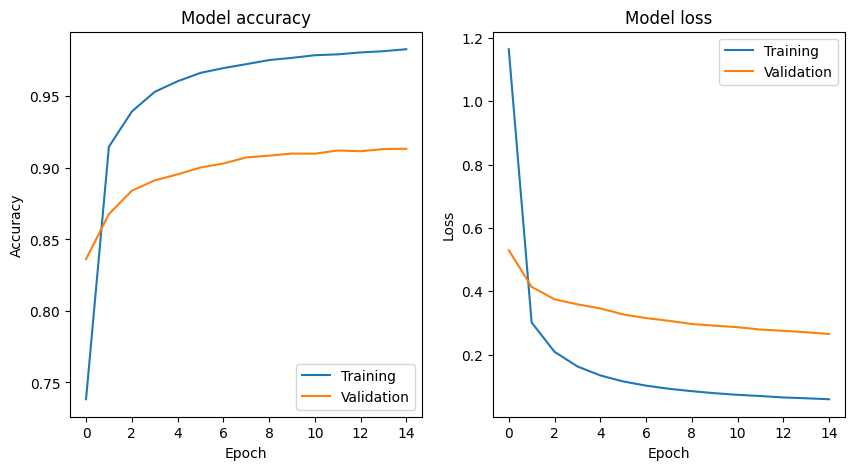

The model has a training accuracy of 98.29%
The model has a validation accuracy of 91.34%


In [154]:
plot_performance(history)

# Model Retraining

In this section, I am increasing the number of epochs to 150 so that the model can continue learning until it starts to overfit (validation loss starts increasing)

In [ ]:
batch_size = 128    # The number of samples seen before the model update the weights
epochs = 150        # Number of training episodes
lr = 0.0001         # Learning rate for the optimizer


optimizer = keras.optimizers.Adam(
    learning_rate = lr
)
model.set_weights(intial_weights)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer1,
              metrics=["accuracy"])

history_1 = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

In [ ]:
plot_performance(history_1)

One can see that the model has started to overfit around 50 epochs. This number is fixed moving forward for the hyperparameter experiment

# Model Hyperparameter Experiment

## Learning Rate Experiment
In the code block below, the learning rate are varied between [0.001, 0.0005, and 0.0001] to evaluate the model training. The number of epochs is fixed at 50 and the batch  size at 128

In [ ]:
history_all = []

batch_size = 128
epochs = 50
lr = [0.001, 0.0005, 0.0001]

for i in range(len(lr)):
    # Reset the weights of the model to start training from the same initial weights
    model.set_weights(intial_weights)

    # Adjust the optimizer with the corresponding learning rate
    optimizer = keras.optimizers.Adam(learning_rate = lr[i])

    model.compile(loss="categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])

    print(f"=== Model training with lr = {lr[i]}, batch size = {batch_size} ===")
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

    # Append a dictionary of the training parameters and training history
    history_all.append({
        'learning_rate': lr[i],
        'batch_size': batch_size,
        'history': history
    })

In [ ]:
for i in range(len(lr)):
    learning_rate_eps = history_all[i]['learning_rate']
    batch_size_eps = history_all[i]['batch_size']

    plot_performance(history_all[i]['history'],learning_rate_eps,batch_size_eps)

## Batch size experiment

In this experiment, I will fix the number of epochs (15) and the learning rate (0.001) while varying the batch size to experiment with the best batch size for this specific problem


In [ ]:
history_all = []

batch_size = [32, 64, 128]
epochs = 15
lr = 0.0001

for i in range(len(batch_size)):
    # Reset the weights of the model to start training from the same initial weights
    model.set_weights(intial_weights)

    # Adjust the optimizer with the corresponding learning rate
    optimizer = keras.optimizers.Adam(learning_rate = lr)

    model.compile(loss="categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])

    print(f"=== Model training with lr = {lr}, batch size = {batch_size[i]} ===")
    history = model.fit(x_train, y_train, batch_size=batch_size[i], epochs=epochs, validation_split=0.2)

    # Append a dictionary of the training parameters and training history
    history_all.append({
        'learning_rate': lr,
        'batch_size': batch_size[i],
        'history': history
    })

In [ ]:
for i in range(len(batch_size)):
    learning_rate_eps = history_all[i]['learning_rate']
    batch_size_eps = history_all[i]['batch_size']

    plot_performance(history_all[i]['history'],learning_rate_eps,batch_size_eps)

## Model Architecture Experiment

In this experiment, all hyperparameters are fixed
* batch size = 128
* learning rate = 0.0001
* epochs = 50

The only changing variable is the number of convolutional layers in the architecture. This number will vary between 2, 3, and 4, convolution layers
* The first convolution layer will have 32 filters
* The subsequent convolution layer(s) will have 64 filters each
* The filters all have size 3x3 and the convolution operations all have a stride of 1

In [ ]:
batch_size = 128
lr = 0.0001
epochs = 50

In [ ]:
tf.keras.backend.clear_session(
    free_memory=True
)

optimizer = keras.optimizers.Adam(
    learning_rate = lr
)

model_2Conv = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(output_classes, activation="softmax"),
])

model_2Conv.summary()

model_2Conv.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

history_2Conv = model_2Conv.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

In [ ]:
tf.keras.backend.clear_session(
    free_memory=True
)

optimizer = keras.optimizers.Adam(
    learning_rate = lr
)

model_3Conv = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(output_classes, activation="softmax"),
])

model_3Conv.summary()

model_3Conv.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

history_3Conv = model_3Conv.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

In [ ]:
tf.keras.backend.clear_session(
    free_memory=True
)

optimizer = keras.optimizers.Adam(
    learning_rate = lr
)

model_4Conv = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(output_classes, activation="softmax"),
])

model_4Conv.summary()

model_4Conv.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

history_4Conv = model_4Conv.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

In [ ]:
plot_performance(history_2Conv)
plot_performance(history_3Conv)
plot_performance(history_4Conv)

# Custom Test Set

## Import the Test Set + Preprocessing
In this section, I will import my own handwritten digits as a custome dataset. The dataset has 25 instances of each digit, meaning 250 samples in total. The samples of each digit is contained within their respective folders with their corresponding name, which also acts as the label since the folder name is later extracted as the custom label. 

The images were previously cropped. In this code, each image is resized to have size 28x28. Since the brushstroke of the handwritten digits were too thin compared to that of the MNIST dataset, I applied an errosion filter on them to widen the brushstroke. I also applied a Gaussian blur mask on the inputs to make the edges less sharp

The path for the import is different on Google Colab and on a PC. For this assignment, I ran model training on my own PC so that path was chosen. Each of the image was resized to 28x28 pixels to match the input shape of the MNIST dataset


In [12]:
import os
import numpy as np
from PIL import Image
import cv2
from tensorflow.keras.utils import to_categorical

output_classes = 10

# Load custom images from Google Drive
custom_images_raw = []
custom_labels_raw = []

# Use the following when working on Google Colab
# base_folder_path = '/content/drive/MyDrive/TME6015/Assignment 1/Custom_Dataset'

# Use the following path when working on PC
base_folder_path = '\\mnguyen\\TME_6015\\Assignment_1\\Custom Set'
# base_folder_path = '\\Minh Nguyen\\TME_6015\\Assignment_1\\Custom Set'
# base_folder_path = 'D:\\Minh Nguyen\\TME_6015\\Assignment_1\\Custom Set'

for folder_name in os.listdir(base_folder_path):
    folder_path = os.path.join(base_folder_path, folder_name)
    print(folder_path)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith('.png') or filename.endswith('.PNG') or filename.endswith('.JPG'):
                img_path = os.path.join(folder_path, filename)
                img = Image.open(img_path).convert('L')  # Convert image to grayscale
                img = img.resize((28, 28))  # Resize image to match MNIST data

                # Thresholding
                threshold = 100
                img = img.point(lambda p: p > threshold and 255)

                img_array = np.array(img)

                # Convert to uint8 for OpenCV
                img_array = np.uint8(img_array)

                # Dilation to thicken brush strokes
                kernel = np.ones((1, 1), np.uint8)  # Create a 5x5 kernel for dilation
                img_eroded = cv2.erode(img_array, kernel, iterations=10)

                # Add some blur on the image to resemble the MNIST training data 
                img_blurred = cv2.GaussianBlur(img_eroded, (3,3), 0.65)

                # Choose which img is used to add in the testing set (eroded or erroed+blurred)
                custom_image_raw = img_blurred

                custom_images_raw.append(custom_image_raw)
                custom_labels_raw.append(int(folder_name))  # Use folder name as label

# Convert the list of custom images and labels to numpy arrays
custom_images_raw = np.array(custom_images_raw)
custom_labels_raw = np.array(custom_labels_raw)

# Preprocess the custom images
custom_images = custom_images_raw / 255.0

# One hot encode the labels
custom_labels = to_categorical(custom_labels_raw, num_classes=output_classes)

print(f"Dimension of the custom_images set: {custom_images.shape}\n"
      f"Dimension of the y_train set: {custom_labels.shape}")


\mnguyen\TME_6015\Assignment_1\Custom Set\0
\mnguyen\TME_6015\Assignment_1\Custom Set\1
\mnguyen\TME_6015\Assignment_1\Custom Set\2
\mnguyen\TME_6015\Assignment_1\Custom Set\3
\mnguyen\TME_6015\Assignment_1\Custom Set\4
\mnguyen\TME_6015\Assignment_1\Custom Set\5
\mnguyen\TME_6015\Assignment_1\Custom Set\6
\mnguyen\TME_6015\Assignment_1\Custom Set\7
\mnguyen\TME_6015\Assignment_1\Custom Set\8
\mnguyen\TME_6015\Assignment_1\Custom Set\9
Dimension of the custom_images set: (250, 28, 28)
Dimension of the y_train set: (250, 10)


In [ ]:
print(custom_labels)

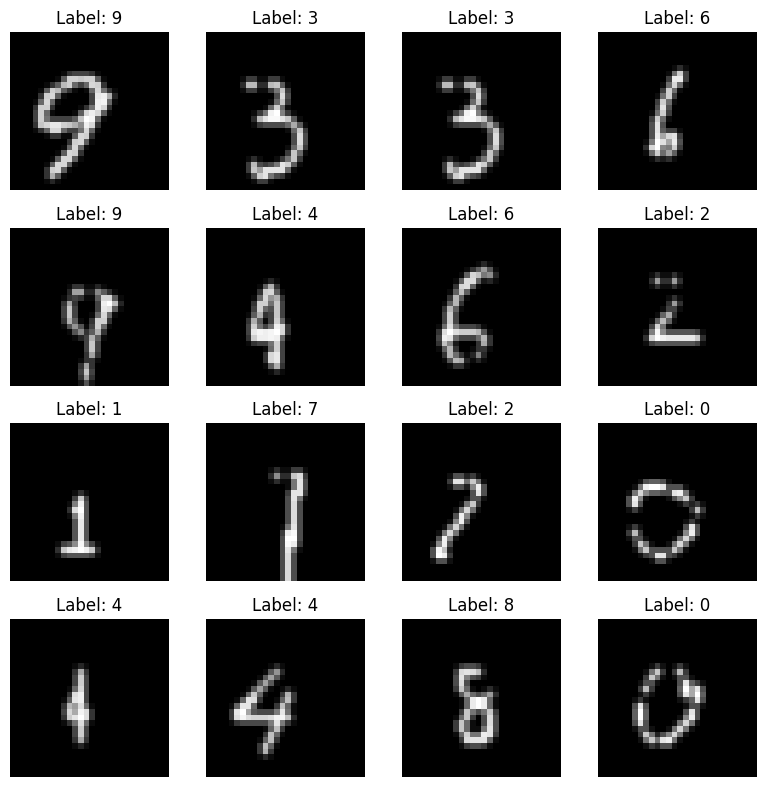

In [13]:
custom_images.shape

num_samples = 16; num_rows = 4; num_cols = np.int8(num_samples/num_rows)
rand = random.randint(250,size = (num_samples))
x_samples = custom_images[rand,:,:]
y_samples = np.argmax(custom_labels[rand],axis=1)

fig, axes = plt.subplots(num_rows,num_cols,figsize=(num_rows*2,num_cols*2))

for i in range(num_rows):
  for j in range(num_cols):
    ax = axes[i,j]
    ax.imshow(x_samples[i*num_cols+j,:,:], cmap=matplotlib.cm.Greys)
    ax.axis("off")
    ax.set_title(f"Label: {y_samples[i*num_cols+j]}")

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust top to make room for title
plt.show()

In [19]:
# Add the custom images and labels to the original MNIST dataset
# x_train = np.concatenate((x_train, custom_images), axis=0)
# y_train = np.concatenate((y_train, custom_labels), axis=0)

keras.backend.clear_session(
    free_memory=True
)

batch_size = 32
lr = 0.001
epochs = 15

optimizer = keras.optimizers.Adam(
    learning_rate = lr
)

model_2Conv = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(output_classes, activation="softmax"),
])

model_2Conv.summary()

model_2Conv.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

history_2Conv = model_2Conv.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,610 (146.91 KB)

 Trainable params: 37,610 (146.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7548 - loss: 0.7586 - val_accuracy: 0.9606 - val_loss: 0.1251
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9471 - loss: 0.1754 - val_accuracy: 0.9739 - val_loss: 0.0914
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9596 - loss: 0.1315 - val_accuracy: 0.9776 - val_loss: 0.0750
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9678 - loss: 0.1090 - val_accuracy: 0.9813 - val_loss: 0.0604
Epoch 5/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9724 - loss: 0.0910 - val_accuracy: 0.9819 - val_loss: 0.0596
Epoch 6/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9756 - loss: 0.0778 - val_accuracy: 0.9826 - val_loss: 0.0579
Epoch 7/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9796 - loss: 0.0669 - val_accuracy: 0.9827 - val_loss: 0.0583
Epoch 8/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9796 - loss: 0.0649 - 

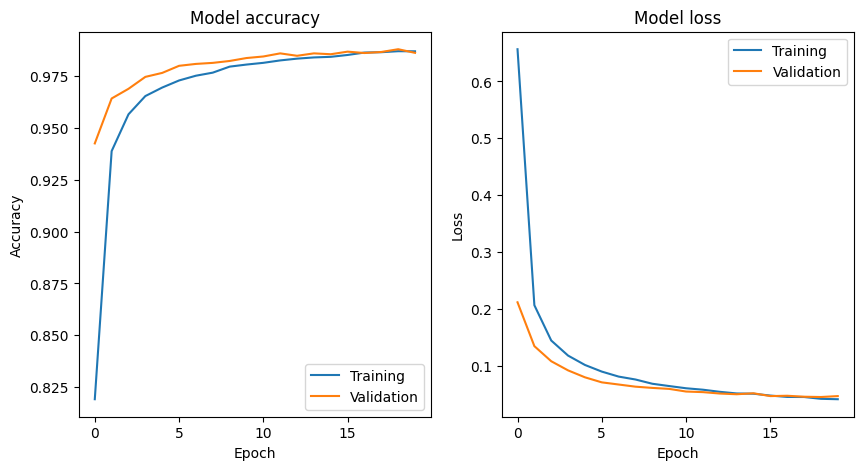

The model has a training accuracy of 98.69%
The model has a validation accuracy of 98.62%


In [16]:
plot_performance(history_2Conv)

## Evaluate the new model performance

In this section, I will retraing a new model from scratch with the following specifications
* 2 convolution layers of size 3x3 and stride 1, each immidiately followed by a max pooling layer of size 2x2, stride 1
* Fully connection at the end to predict the 10 classes using a softmax function
* Hyperparameters: batch_size = 128, lr = 0.001, epochs = 20

After evaluating the training process (training + validation loss/accuracy), I will evaluate this model on the custom test set and compare it with an earlier model

In [17]:
test_model = model_2Conv

custom_loss, custom_accuracy = test_model.evaluate(custom_images, custom_labels, verbose=1)
print(f"Custom Data - Loss: {custom_loss}, Accuracy: {custom_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2123 - loss: 2.6950
Custom Data - Loss: 2.9297144412994385, Accuracy: 0.15199999511241913


In the following code block, I am using the trained model to make predictions on the custom dataset. Afterward, I will visualize the model prediction and compare it with the label imported from the custom set

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[1 1 5 7 1 1 5 1 1 1 1 1 1 5 1 5 1 1 1 1 5 1 5 5 1 1 1 1 5 1 1 1 7 1 1 5 5
 1 1 1 1 1 7 1 1 1 1 1 7 1 1 1 1 1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1
 1 1 1 1 1 1 1 5 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


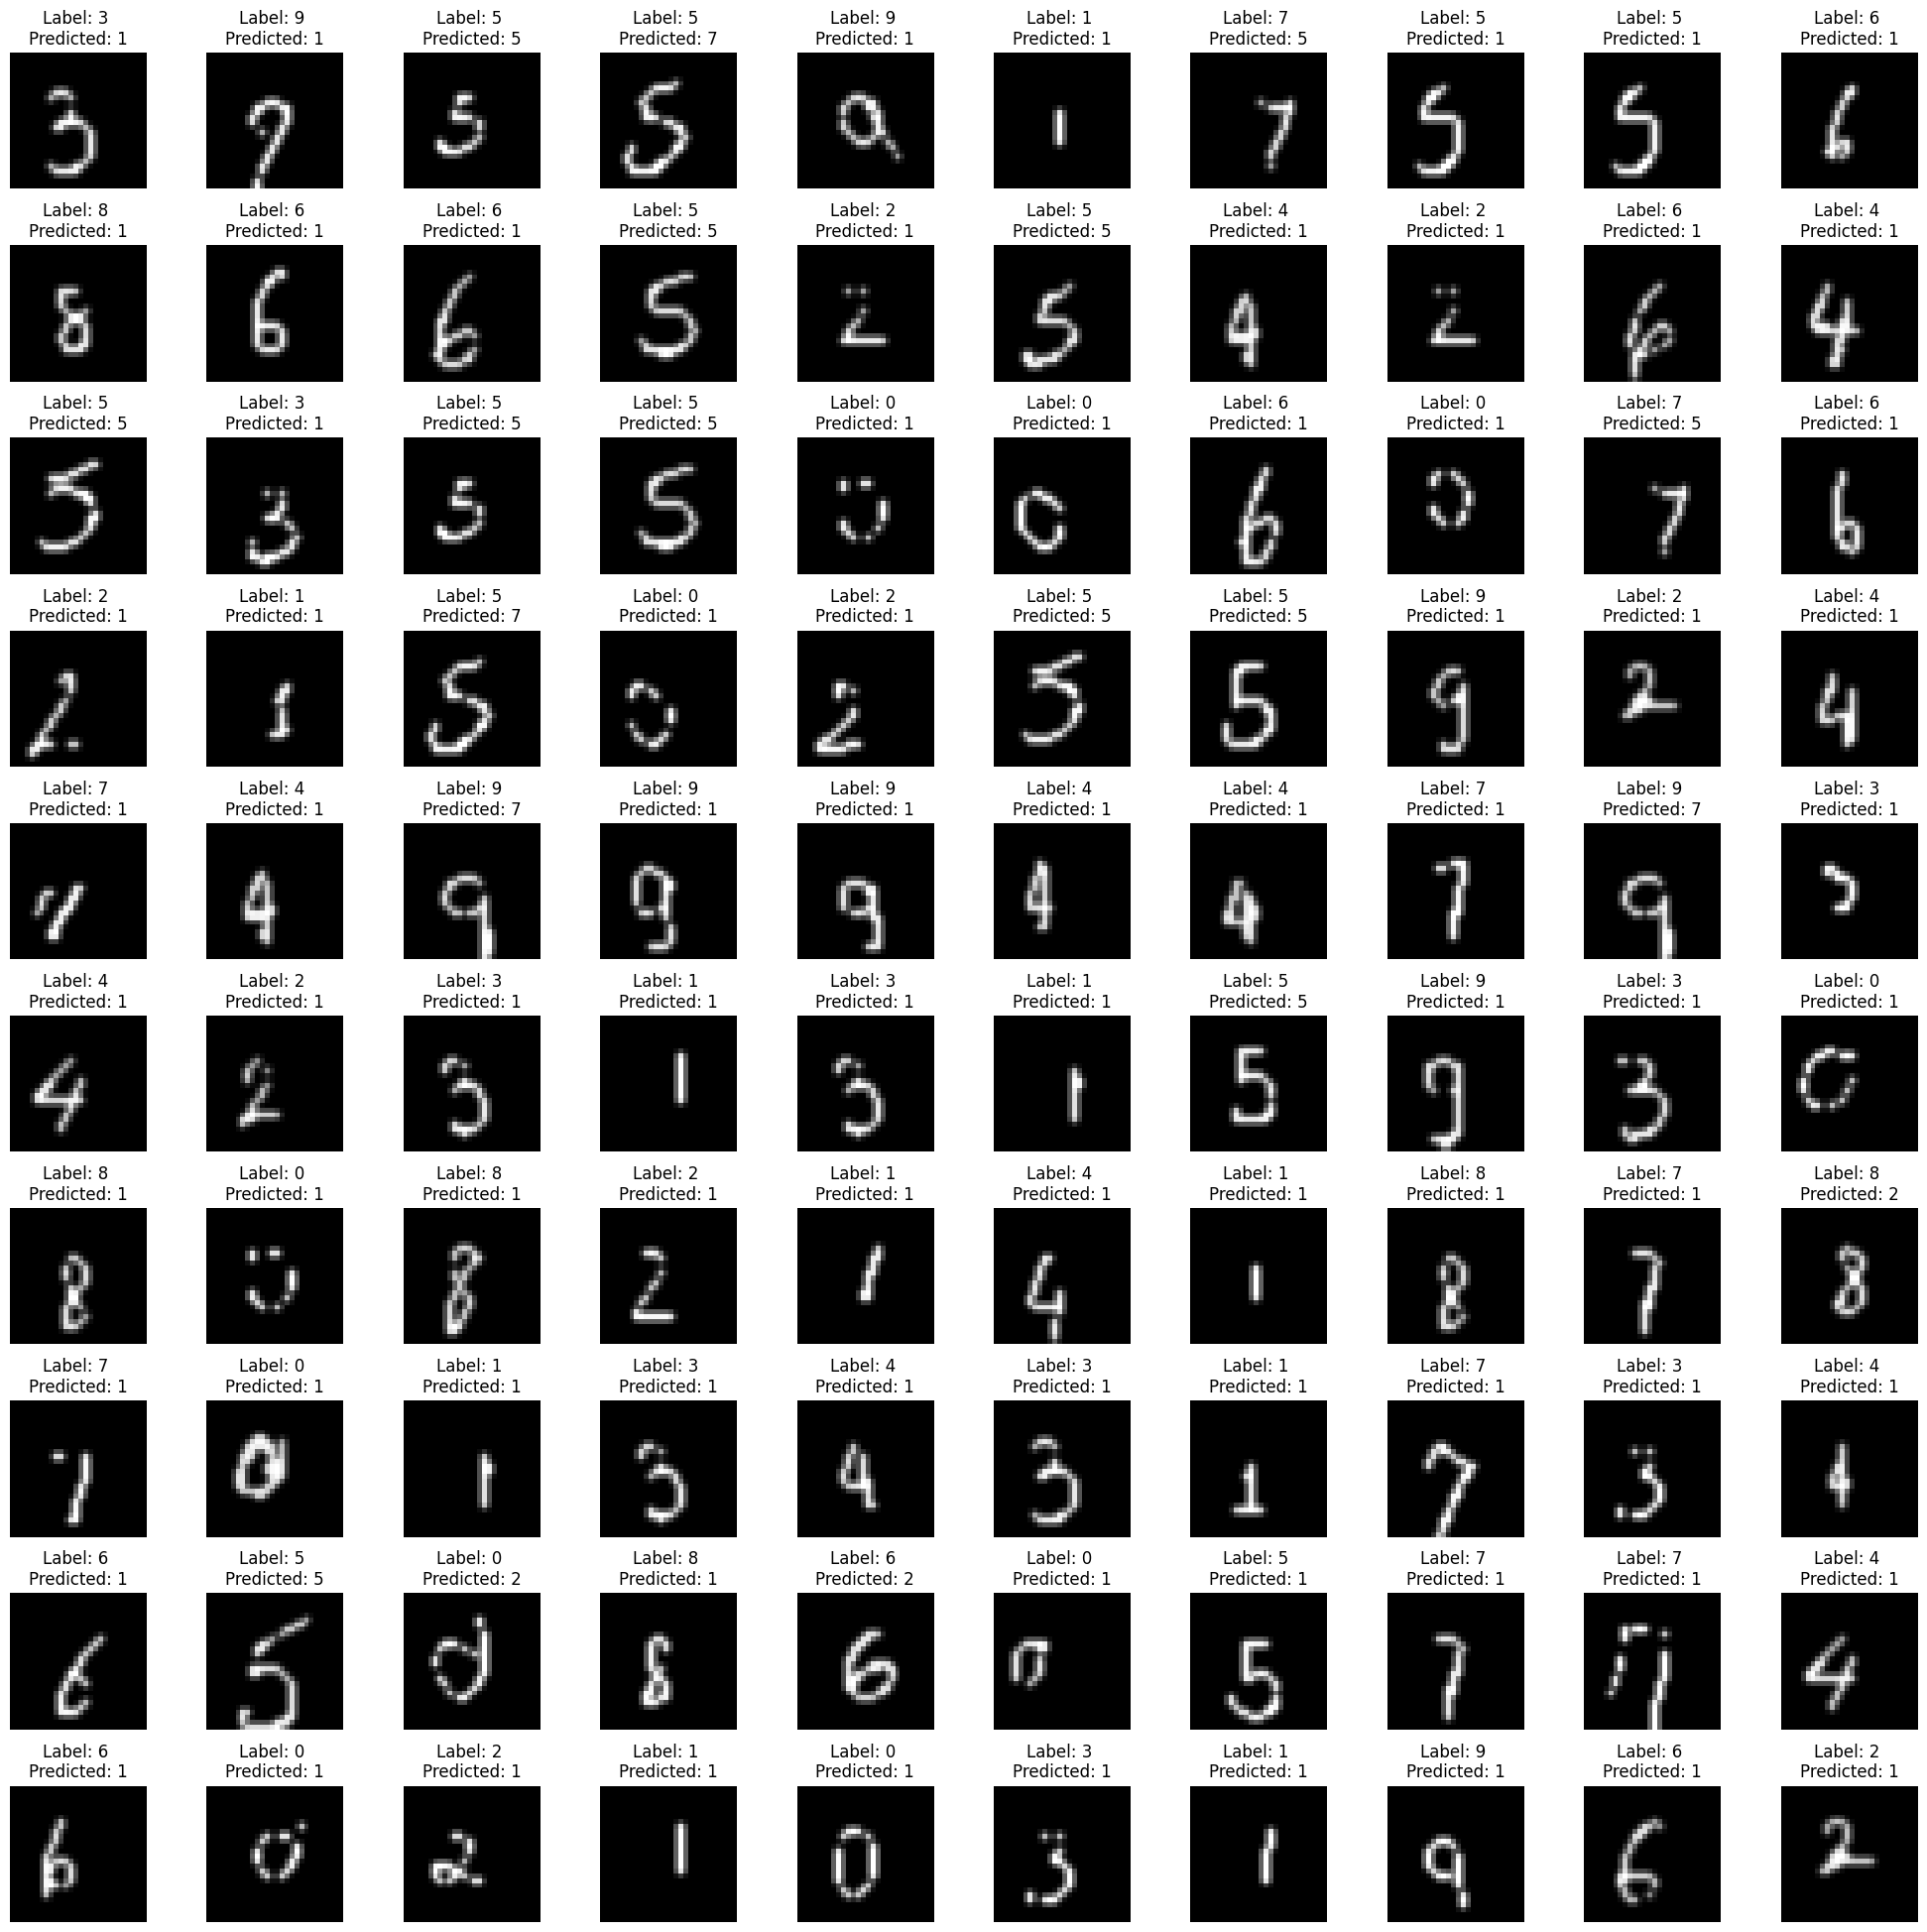

In [18]:
custom_images.shape

num_samples = 100; num_rows = np.int8(np.sqrt(num_samples)); num_cols = np.int8(num_samples/num_rows)
rand = random.randint(250,size = (num_samples))
x_samples = custom_images[rand,:,:]
y_samples = np.argmax(custom_labels[rand],axis=1)

predictions = test_model.predict(custom_images)
y_predicted = np.argmax(predictions[rand],axis=1)
print(y_predicted)

fig, axes = plt.subplots(num_rows,num_cols,figsize=(num_rows*2,num_cols*2))

for i in range(num_rows):
  for j in range(num_cols):
    ax = axes[i,j]
    ax.imshow(x_samples[i*num_cols+j,:,:], cmap=matplotlib.cm.Greys)
    ax.axis("off")
    ax.set_title(f"Label: {y_samples[i*num_cols+j]} \n"
                 f"Predicted: {y_predicted[i*num_cols+j]}")

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust top to make room for title
plt.show()

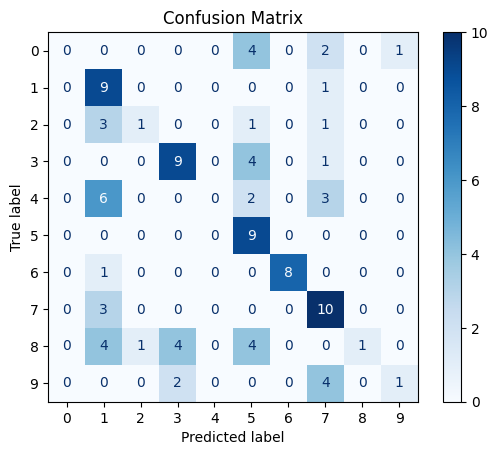

In [170]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_samples, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)  # You can change the color map as desired
plt.title("Confusion Matrix")
plt.show()

From this confusion matrix, it seems that the model performs well when trying to predict 1, 3, 5, 6, and 7. 
However, a lot of the time the model mistake a 4 as a 1, an 8 as a 1, 3, or 5. This may arise from the quality of the testing images and the preprocessing steps take